In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
import string
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [3]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [4]:
import missingno as msno

In [5]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:>

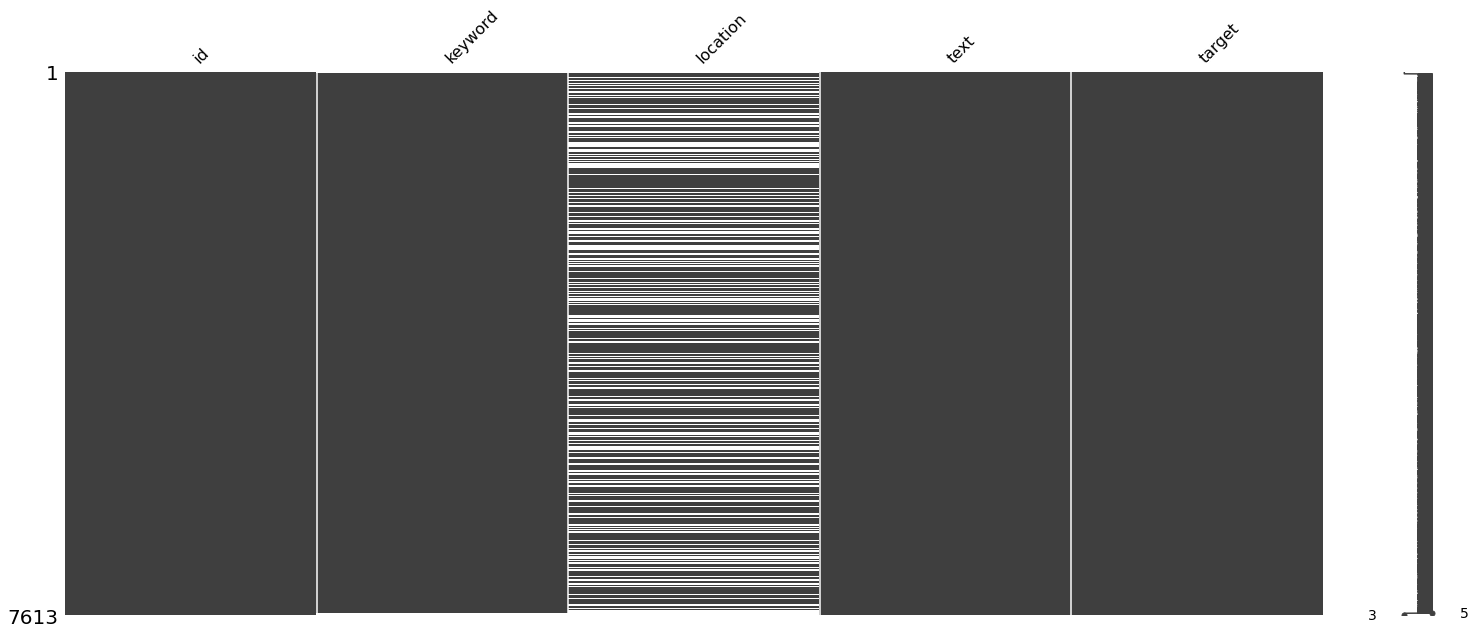

In [7]:
msno.matrix(train_df)

In [8]:
train_df[train_df.location.isna()]['target'].value_counts()

0    1458
1    1075
Name: target, dtype: int64

In [9]:
train_df[train_df.location.isna()]['keyword'].value_counts()

razed                    25
detonation               24
explosion                21
suicide%20bomber         20
nuclear%20disaster       19
                         ..
collision                 3
epicentre                 3
snowstorm                 3
radiation%20emergency     3
threat                    1
Name: keyword, Length: 221, dtype: int64

**PREPARING DATA**

In [10]:
def prepare_the_data(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text) #remove url
    text = re.sub(r'[^\w\s]', '', text) #remove punctuations
    text = re.sub(r"0\S+" , '',  text) #remove words that start with
    text = re.sub(r'\s+', ' ',   text) #remove duplicate whitespaces
    return text

In [11]:
train_df['clean_text'] = train_df['text'].apply(lambda x: prepare_the_data(x))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_df['clean_text'].values, train_df.target.values, test_size = 0.33)

In [13]:
vocab_size = 20000
embedding_dim = 8
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
training_padded = np.array(training_padded)
training_labels = y_train
testing_padded = np.array(testing_padded)
testing_labels = y_test

In [16]:
training_padded.shape

(5100, 100)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), #Turns positive integers (indexes) into dense vectors of fixed size.
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(12, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.06)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2023-01-23 19:53:23.922809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:53:23.923808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:53:24.091811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:53:24.092798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:53:24.093634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 8)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 160,121
Trainable params: 160,121
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 70
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/70


2023-01-23 19:53:27.836811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


160/160 - 3s - loss: 1.0899 - accuracy: 0.5651 - val_loss: 0.9261 - val_accuracy: 0.5770
Epoch 2/70
160/160 - 1s - loss: 0.8407 - accuracy: 0.5671 - val_loss: 0.7724 - val_accuracy: 0.5770
Epoch 3/70
160/160 - 1s - loss: 0.7400 - accuracy: 0.5671 - val_loss: 0.7121 - val_accuracy: 0.5770
Epoch 4/70
160/160 - 1s - loss: 0.7019 - accuracy: 0.5671 - val_loss: 0.6906 - val_accuracy: 0.5770
Epoch 5/70
160/160 - 1s - loss: 0.6885 - accuracy: 0.5671 - val_loss: 0.6835 - val_accuracy: 0.5770
Epoch 6/70
160/160 - 1s - loss: 0.6849 - accuracy: 0.5671 - val_loss: 0.6815 - val_accuracy: 0.5770
Epoch 7/70
160/160 - 1s - loss: 0.6837 - accuracy: 0.5671 - val_loss: 0.6808 - val_accuracy: 0.5770
Epoch 8/70
160/160 - 1s - loss: 0.6831 - accuracy: 0.5671 - val_loss: 0.6806 - val_accuracy: 0.5770
Epoch 9/70
160/160 - 1s - loss: 0.6824 - accuracy: 0.5671 - val_loss: 0.6803 - val_accuracy: 0.5770
Epoch 10/70
160/160 - 1s - loss: 0.6814 - accuracy: 0.5671 - val_loss: 0.6795 - val_accuracy: 0.5770
Epoch 11/7

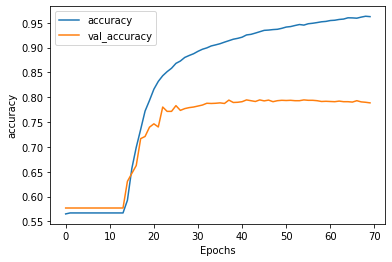

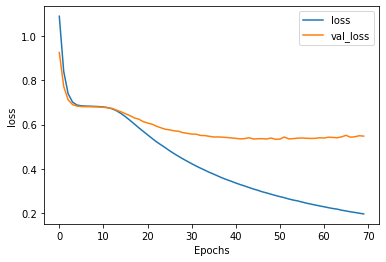

In [20]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [21]:
lay = model.layers[0]
weights = lay.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(20000, 8)


In [22]:
test_df['clean_text']=test_df['text'].apply(lambda x: prepare_the_data(x))

In [23]:
sentences = test_df['clean_text'].values
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
res=model.predict(padded)
no=np.where(res<=0.5)[0]
yes=np.where(res>0.5)[0]

In [24]:
target=np.zeros(len(test_df['id']), dtype=int)
target[yes]=1

In [25]:
submission=pd.DataFrame()
submission['id']=test_df['id']
submission['target']=target

In [26]:
submission.to_csv(r'submission.csv', header=True, index=False)